
# Matter distribution

This example simulates only the matter field in nested shells up to redshift 1.


## Setup
Set up a matter-only GLASS simulation, which requires angular matter power
spectra and the sampling itself (here: lognormal).

Uses the saved angular matter power spectra from the :doc:`/basic/shells`
example.



In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# uses the CAMB cosmology which produced the cls
import camb
from cosmology import Cosmology

# these are the GLASS imports: matter and random fields
import glass.shells
import glass.fields


# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# basic parameters of the simulation
nside = 1024
lmax = 1000

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2,
                       NonLinear=camb.model.NonLinear_both)

# get the cosmology from CAMB
cosmo = Cosmology.from_camb(pars)

# shells of 200 Mpc in comoving distance spacing
zb = glass.shells.distance_grid(cosmo, 0., 1., dx=200.)

# load precomputed angular matter power spectra
cls = np.load('cls.npy')

# compute Gaussian cls for lognormal fields with 3 correlated shells
gls = glass.fields.lognormal_gls(cls, ncorr=3, nside=nside)

# this generator will yield the matter fields in each shell
matter = glass.fields.generate_lognormal(gls, nside, ncorr=3)

## Simulation
Run the simulation.  For each shell, plot an orthographic annulus of the
matter distribution.



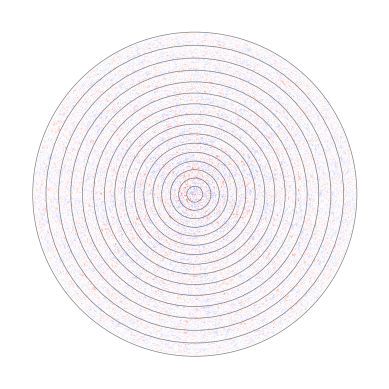

In [2]:
# make a 2d grid in redshift
n = 2000
zend = 1.05*zb[-1]
x, y = np.mgrid[-zend:zend:1j*n, -zend:zend:1j*n]
z = np.hypot(x, y)
grid = np.full(z.shape, np.nan)

# set up the plot
ax = plt.subplot(111)
ax.axis('off')

# simulate and project an annulus of each matter shell onto the grid
for i, delta_i in enumerate(matter):
    zmin, zmax = zb[i], zb[i+1]
    g = (zmin <= z) & (z < zmax)
    zg = np.sqrt(1 - (z[g]/zmax)**2)
    theta, phi = hp.vec2ang(np.transpose([x[g]/zmax, y[g]/zmax, zg]))
    grid[g] = hp.get_interp_val(delta_i, theta, phi)
    ax.add_patch(plt.Circle((0, 0), zmax/zend, fc='none', ec='k', lw=0.5, alpha=0.5, zorder=1))

# show the grid of shells
ax.imshow(grid, extent=[-1, 1, -1, 1], zorder=0,
          cmap='bwr', vmin=-2, vmax=2)

# show the resulting plot
plt.show()